# Import and Config

In [1]:
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz
from discofuzz.EvalHarness import EvalHarness

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
from sklearn.decomposition import PCA
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
n_components = 5
fuzzification_kernel_size = 8
enrich_lemmas_with_wn = False
full_eval = False

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".")
if not full_eval:
    sample_size = 1000
    X_train, y_train, X_test, y_test = (
        X_train[:sample_size],
        y_train[:sample_size],
        # X_train[:sample_size],
        # y_train[:sample_size],
        X_test[:sample_size],
        y_test[:sample_size]
    )
# evaluating space on full, combined training+test set, as fuzzification model is nonparametric
X_test = pd.concat([X_train, X_test])
y_test = pd.concat([y_train, y_test])

sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel(
    dim_reduc=PCA(n_components=n_components)
)
model = DisCoFuzz(
    embedding_model,
    enrich_lemmas_with_wn=enrich_lemmas_with_wn
)
eval_harness = EvalHarness(
    sim_metrics=sim_metrics_enum,
    composition_strategies=STRATEGIES,
    embedding_model=embedding_model,
    spacy_model=model.spacy_model,
    fuzzifier=model.lemma_vectorizer.fuzzifier,
)

# Run model

In [4]:
sents = X_test["sent_1"].to_list() + X_test["sent_2"].to_list()
embedding_model.fit_transform(sents)

array([[ 0.24957755,  0.07054903,  0.0521041 ,  0.09182768,  0.05954018],
       [ 0.07095665, -0.16807061, -0.19230807,  0.04152134, -0.07100429],
       [ 0.16783795,  0.19558492, -0.2504133 ,  0.20973964, -0.15322967],
       ...,
       [-0.23239899,  0.06284291,  0.16999549, -0.03374016, -0.01399692],
       [-0.11297864, -0.12256503, -0.10313436,  0.04488255, -0.02545167],
       [ 0.03337013, -0.09016228, -0.07229991,  0.08935645, -0.10032115]],
      dtype=float32)

In [5]:
X_test = model.fit(X_test)
X_test = model.predict_batch(X_test, STRATEGIES)

	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


# Evaluate models

In [6]:
eval_harness.fit(X_test)
sims_df = eval_harness.get_similarities(X_test)
sims_df.head()

(2000, 5)
(2000, 5)

	=== Computing similarities with cos metric ===
		Getting compositional embedding relatedness scores for baseline_sent approach...
		Getting compositional embedding relatedness scores for baseline_tok approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...

	=== Computing similarities with wasserstein-1 metric ===
		Getting compositional embedding relatedness scores for b

,baseline_sent_cos_sim_components=0,baseline_sent_cos_sim_components=1,baseline_sent_cos_sim_components=2,baseline_sent_cos_sim_components=3,baseline_sent_cos_sim_components=4,baseline_tok_cos_sim_components=0,baseline_tok_cos_sim_components=1,baseline_tok_cos_sim_components=2,baseline_tok_cos_sim_components=3,baseline_tok_cos_sim_components=4,...,fuzzy_selective_intersection+mean_quantum_sim_components=0,fuzzy_selective_intersection+mean_quantum_sim_components=1,fuzzy_selective_intersection+mean_quantum_sim_components=2,fuzzy_selective_intersection+mean_quantum_sim_components=3,fuzzy_selective_intersection+mean_quantum_sim_components=4,fuzzy_selective_intersection+union_quantum_sim_components=0,fuzzy_selective_intersection+union_quantum_sim_components=1,fuzzy_selective_intersection+union_quantum_sim_components=2,fuzzy_selective_intersection+union_quantum_sim_components=3,fuzzy_selective_intersection+union_quantum_sim_components=4
0,0.427,0.363974,0.154346,0.055700,0.079956,0.0245,0.070000,0.116989,0.157028,0.142061,...,0.006666,0.011376,0.011587,0.014729,0.017012,0.051025,0.054884,0.054884,0.052306,0.051643
1,0.427,-0.479097,-0.469483,-0.412176,-0.277542,0.0245,0.051198,0.081095,0.117285,0.106581,...,0.006520,0.011229,0.011491,0.014634,0.016928,0.050942,0.054832,0.054851,0.052283,0.051663
2,0.427,-0.423594,-0.545666,-0.477313,-0.309417,0.0245,-0.099522,-0.181403,-0.330775,-0.323164,...,0.006671,0.011377,0.011554,0.014687,0.016977,0.050963,0.054840,0.054850,0.052274,0.051646
3,-0.573,-0.130637,-0.095575,-0.070012,-0.108157,0.0245,-0.026552,-0.058925,-0.005276,-0.024174,...,0.006670,0.011379,0.010973,0.014125,0.016072,0.051032,0.054888,0.054889,0.052310,0.051684
4,-0.573,0.352609,0.336997,0.329224,0.322632,0.0245,0.074974,0.100999,0.152427,0.109513,...,0.006572,0.011285,0.011312,-0.014165,-0.010140,-0.197190,-0.212447,-0.212070,-0.203082,-0.200482


In [7]:
sim_eval_df = eval_harness.classify_similarities(sims_df)

C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\EvalHarness.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred[f"{c}_pred"] = X[c] > 0
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\EvalHarness.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred[f"{c}_pred"] = X[c] > 0
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\EvalHarness.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

# Visualizations

## Custom similarities vs cosine similarity in original space

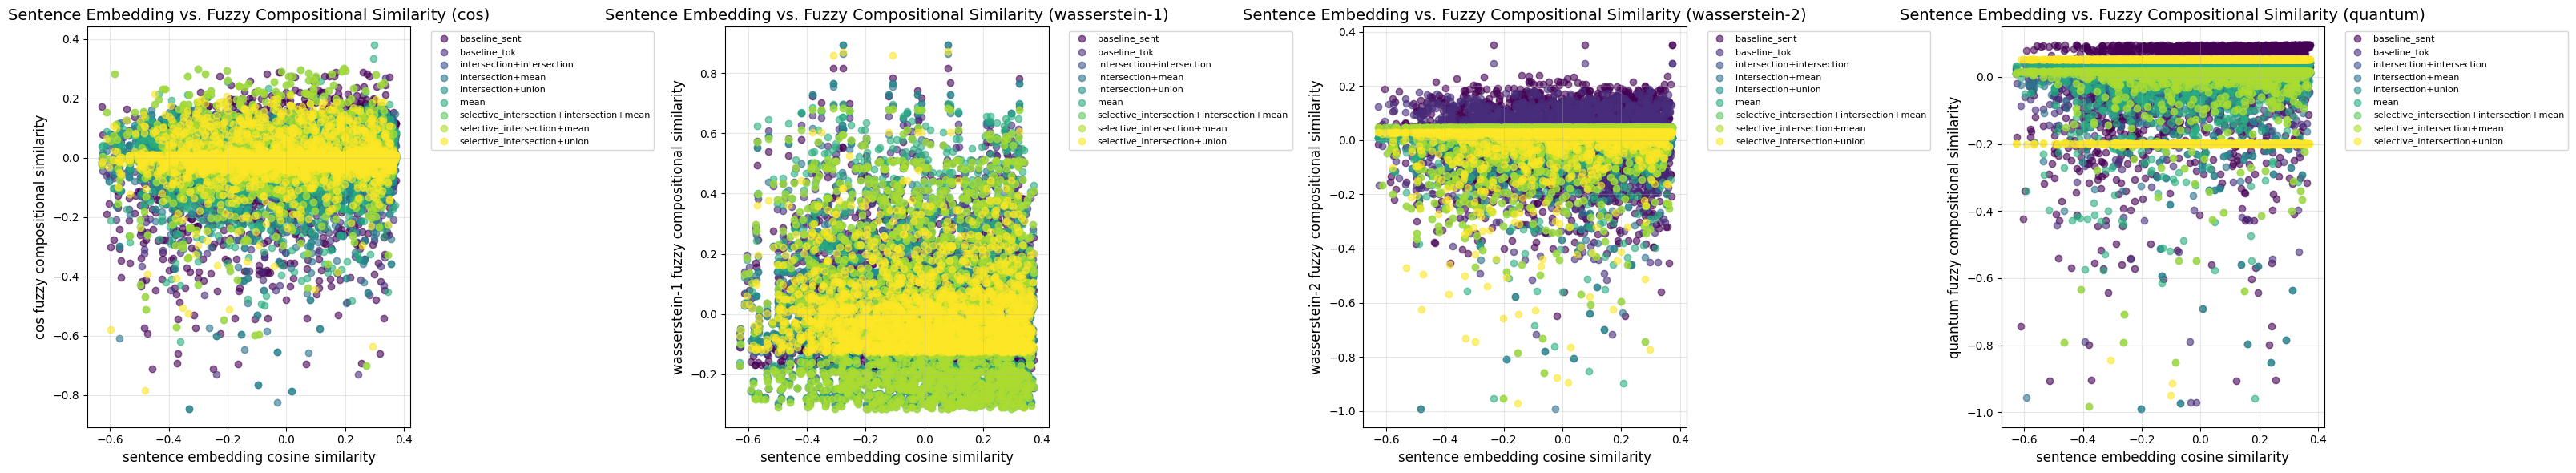

In [8]:
eval_harness.visualize_similarities(sims_df, dimensionality=n_components)

## Confusion Matrices

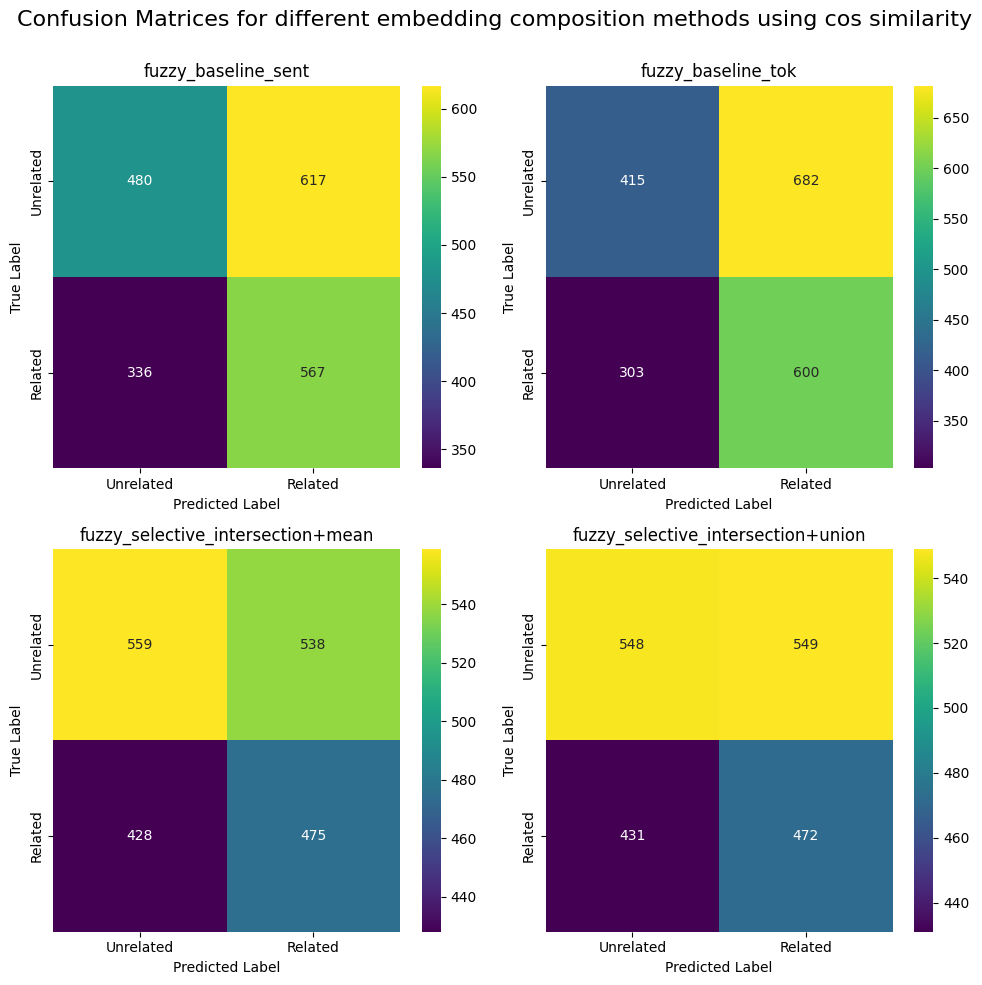

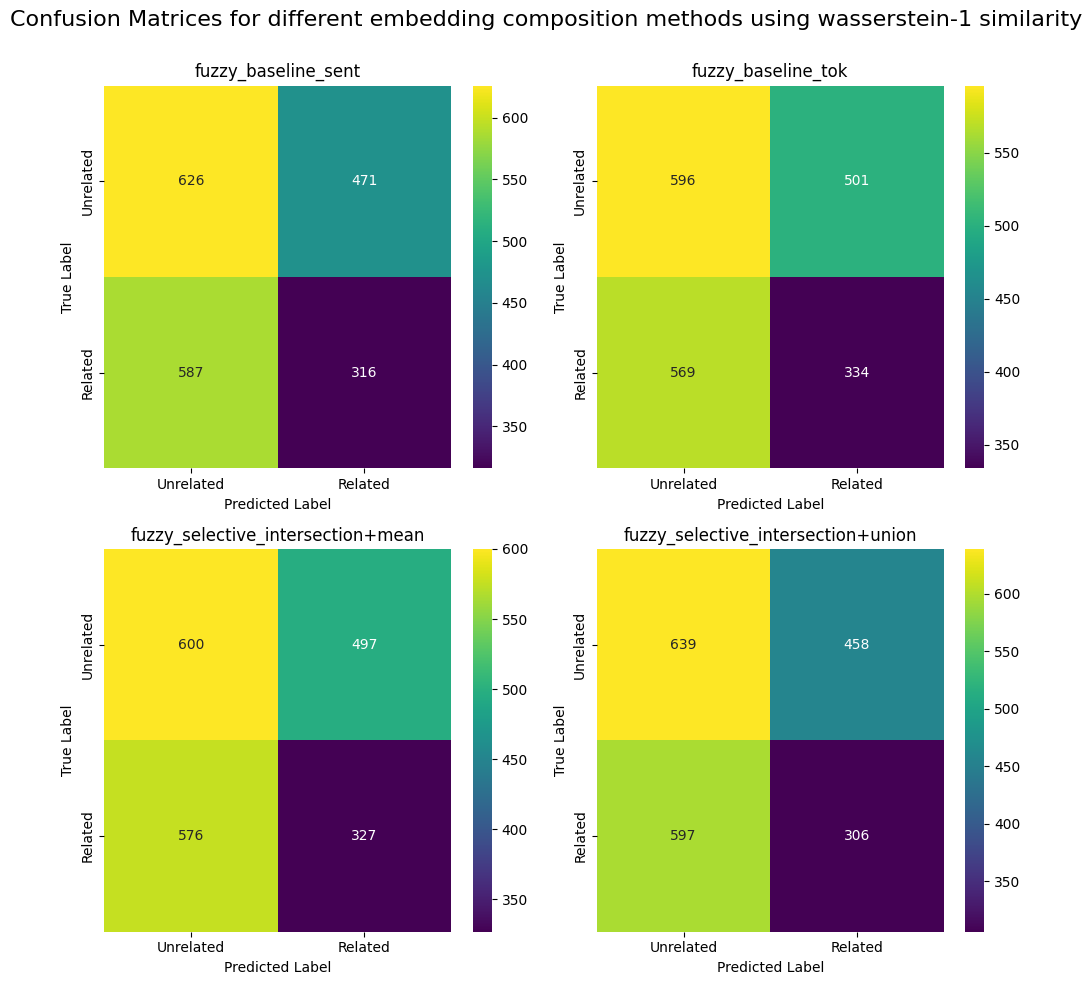

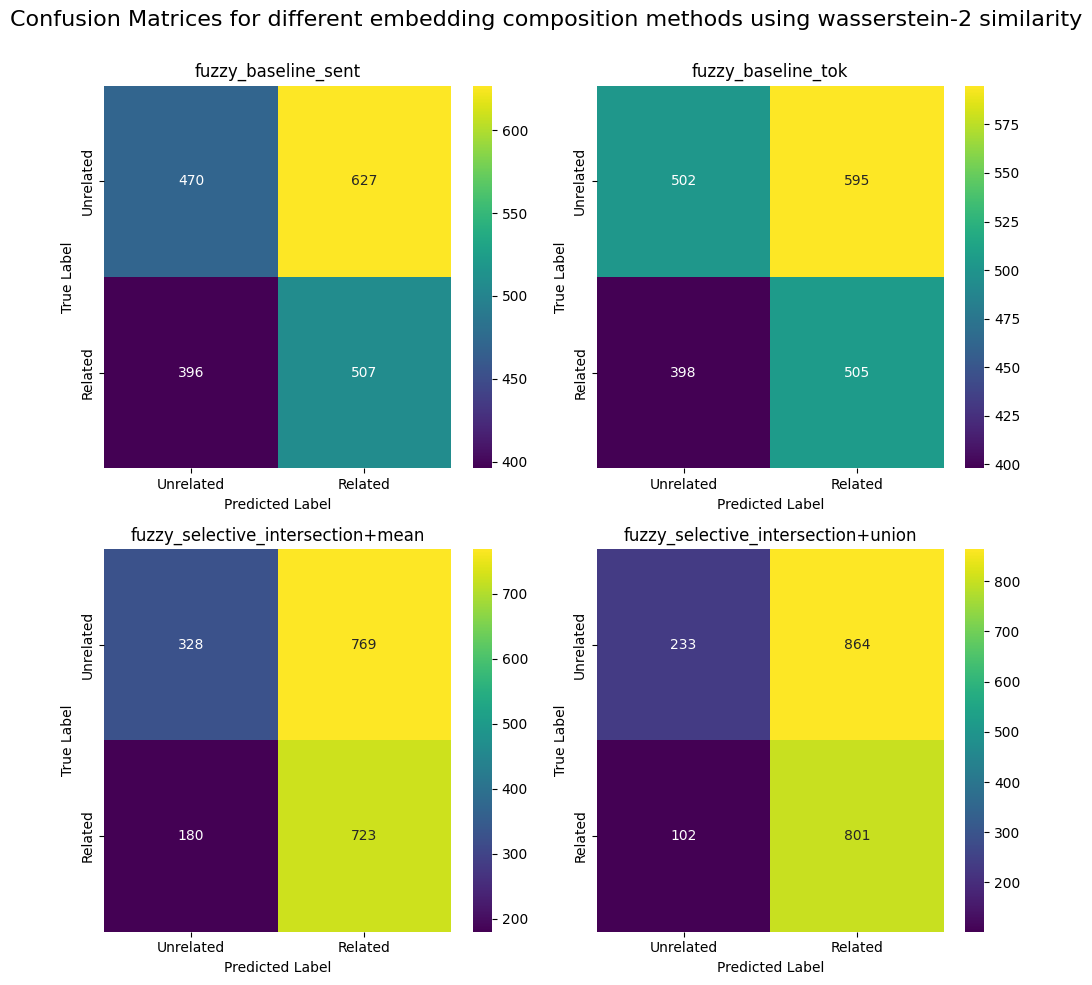

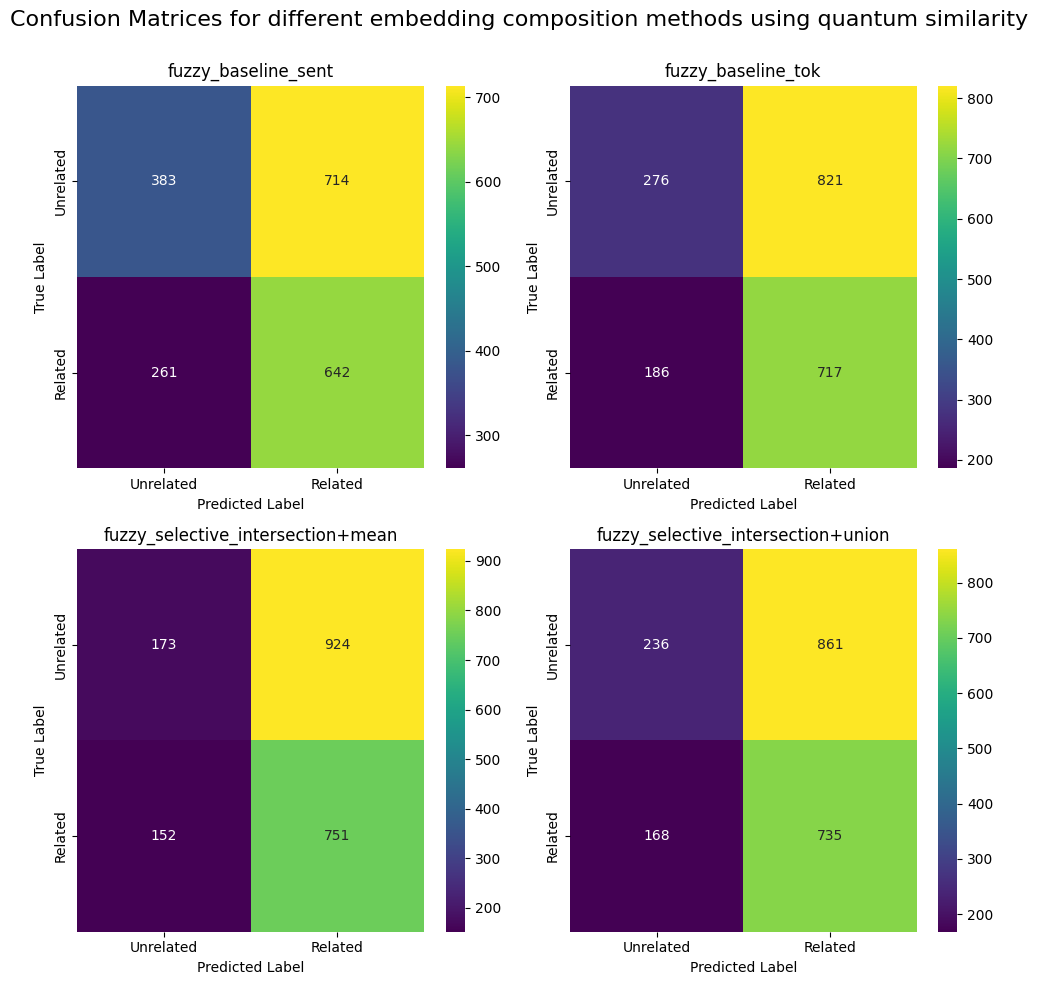

In [9]:
models = [
    "baseline_sent",
    "baseline_tok",
    "selective_intersection+mean",
    "selective_intersection+union",
]
metric_cols = []
for sim_metric in sim_metrics:
    metric_cols.extend([
        f"{fmt_dim_reduc_sim_col(f'fuzzy_{model}_{sim_metric}', n_components-1)}_pred"
        for model in models
    ])
eval_harness.plot_confusion_matrices(
    X=sim_eval_df[metric_cols],
    y=y_test,
    dimensionality=n_components
)

# Evaluation Results

In [10]:
sim_eval_df.head()

,baseline_sent_cos_sim_components=0_pred,baseline_sent_cos_sim_components=1_pred,baseline_sent_cos_sim_components=2_pred,baseline_sent_cos_sim_components=3_pred,baseline_sent_cos_sim_components=4_pred,baseline_tok_cos_sim_components=0_pred,baseline_tok_cos_sim_components=1_pred,baseline_tok_cos_sim_components=2_pred,baseline_tok_cos_sim_components=3_pred,baseline_tok_cos_sim_components=4_pred,...,fuzzy_selective_intersection+mean_quantum_sim_components=0_pred,fuzzy_selective_intersection+mean_quantum_sim_components=1_pred,fuzzy_selective_intersection+mean_quantum_sim_components=2_pred,fuzzy_selective_intersection+mean_quantum_sim_components=3_pred,fuzzy_selective_intersection+mean_quantum_sim_components=4_pred,fuzzy_selective_intersection+union_quantum_sim_components=0_pred,fuzzy_selective_intersection+union_quantum_sim_components=1_pred,fuzzy_selective_intersection+union_quantum_sim_components=2_pred,fuzzy_selective_intersection+union_quantum_sim_components=3_pred,fuzzy_selective_intersection+union_quantum_sim_components=4_pred
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,False,False,False,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,False,False,False,False,True,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,True,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
4,False,True,True,True,True,True,True,True,True,True,...,True,True,True,False,False,False,False,False,False,False


In [11]:
scores_df = eval_harness.score(sim_eval_df, y_test)
scores_df[:5]

,fuzzy,strategy,similarity_metric,n_components,model,accuracy,precision,recall,f1_score
0,True,selective_intersection+union,wasserstein-2,4,selective_intersection+union_wasserstein-2,0.5170,0.481081,0.887043,0.623832
1,True,selective_intersection+union,wasserstein-2,1,selective_intersection+union_wasserstein-2,0.5035,0.474018,0.909192,0.623150
2,True,selective_intersection+union,wasserstein-2,0,selective_intersection+union_wasserstein-2,0.4940,0.469399,0.925803,0.622951
3,True,intersection+intersection,wasserstein-2,1,intersection+intersection_wasserstein-2,0.4655,0.456681,0.968992,0.620788
4,True,intersection+union,wasserstein-2,1,intersection+union_wasserstein-2,0.4655,0.456681,0.968992,0.620788


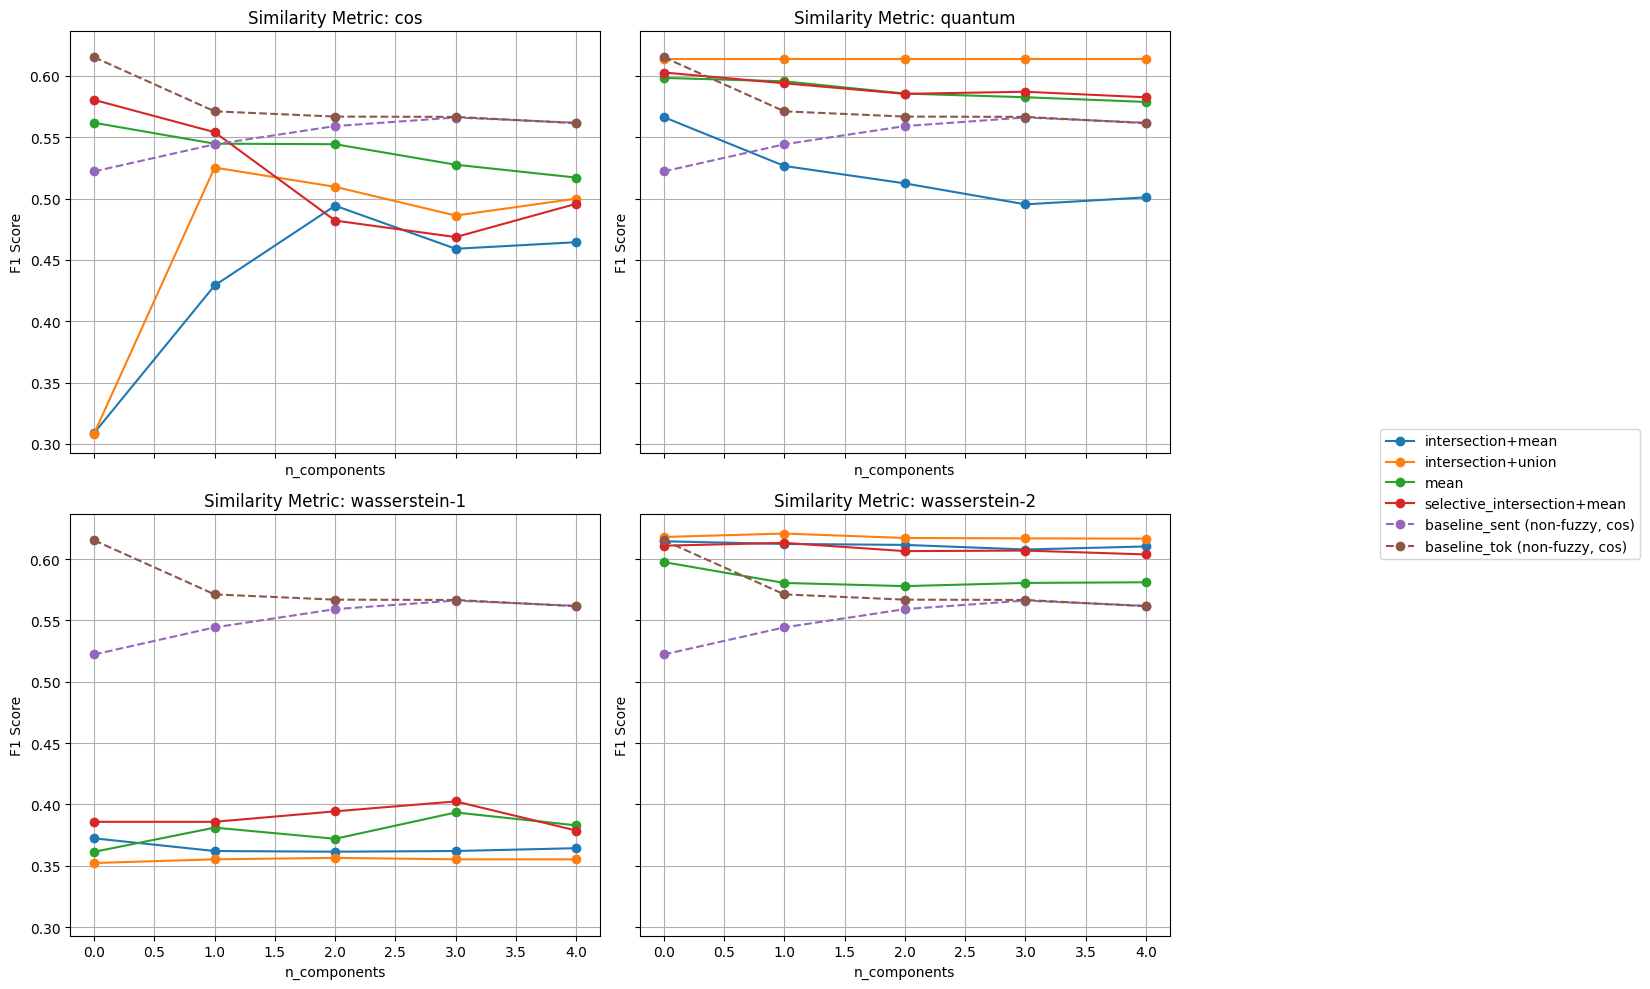

In [12]:
strategies_to_plot = [
    "mean",
    "intersection+mean",
    "intersection+union",
    "selective_intersection+mean"
]

eval_harness.visualize_f1_by_metric_n_components(scores_df, strategies=strategies_to_plot)

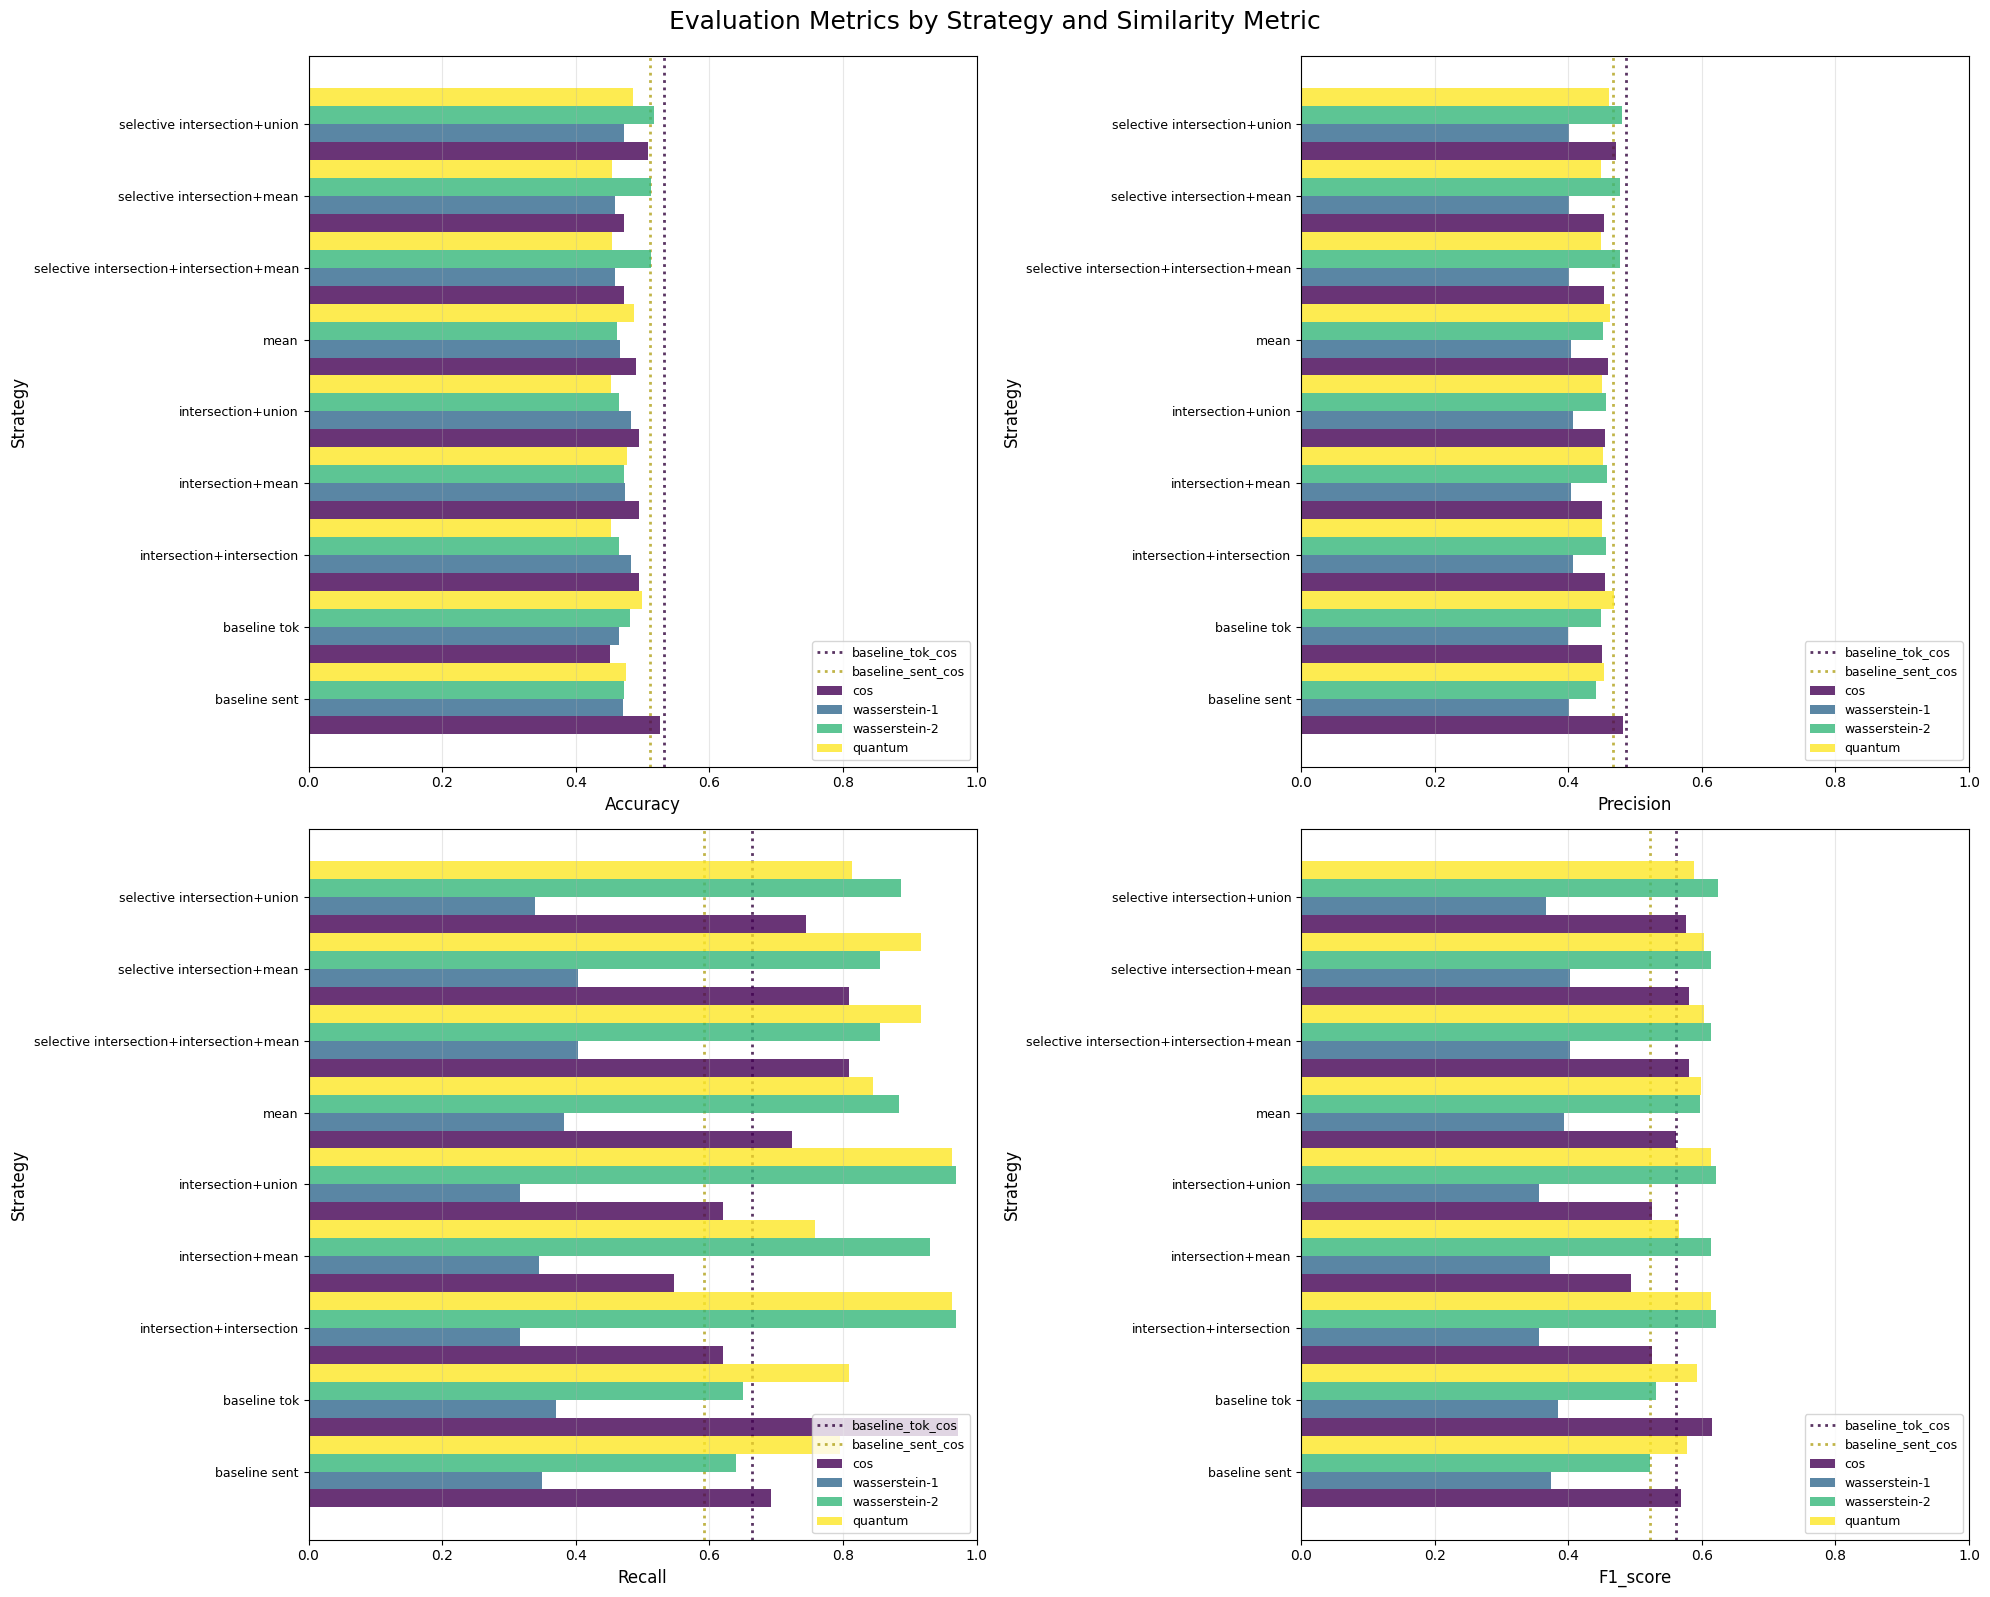

In [13]:
eval_harness.visualize_scores(scores_df, n_components)

In [14]:
scores_df.to_csv(f"full_eval={full_eval},wn_enriched={enrich_lemmas_with_wn},n_components={n_components},kernel_size={fuzzification_kernel_size}.tsv", sep="\t")